<a href="https://colab.research.google.com/github/devanshsingh2004/curriculum-dqn-breakout/blob/main/Q3_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1 – Installs & Imports

In [5]:
# Install Atari support & ROMs
!pip install -q gym[atari,accept-rom-license] autorom
!AutoROM --accept-license

import os, random, time
import numpy as np
# patch for TF compatibility
np.bool8 = np.bool_

import gym
from gym.wrappers import AtariPreprocessing, FrameStack, RecordVideo
from collections import deque

import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, losses, metrics

import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print("GPU devices:", tf.config.list_physical_devices('GPU'))


AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/backgammon.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/bank_heist.bin
Inst

Cell 2 – Environment + Curriculum + Video Recording

In [6]:
def make_env():
    base = gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array")
    base = AtariPreprocessing(base, screen_size=84, grayscale_obs=True, scale_obs=True)
    return FrameStack(base, 4)

class CurriculumBreakout(gym.Wrapper):
    def __init__(self, env, spike_prob=0.0, diff_interval=500):
        super().__init__(env)
        self.spike_prob    = spike_prob
        self.diff_interval = diff_interval
        self.frame_count   = 0

    def step(self, action):
        self.frame_count += 1
        spike = (random.random() < self.spike_prob)
        if spike: print("🎯 Difficulty spike!")
        if self.frame_count % self.diff_interval == 0:
            print("🛶 Paddle size changed.")

        out = self.env.step(action)
        if len(out) == 5:
            obs, reward, terminated, truncated, info = out
        else:
            obs, reward, done, info = out
            terminated, truncated = done, False

        info = info or {}
        info['spike'] = float(spike)
        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        self.frame_count = 0
        return self.env.reset(**kwargs)


Cell 3 – DQNAgent w/ Detection Head & Recovery Time

In [7]:
class DQNAgent:
    def __init__(self, n_actions,
                 gamma=0.99, lr=2.5e-4,
                 batch_size=32, mem_size=100_000,
                 train_freq=4, target_update=1000,
                 detect_threshold=0.5):
        # hyperparams
        self.n_actions     = n_actions
        self.gamma         = gamma
        self.batch_size    = batch_size
        self.train_freq    = train_freq
        self.target_update = target_update

        # ε‐greedy
        self.epsilon       = 1.0
        self.epsilon_min   = 0.1
        self.epsilon_decay = 0.9995

        # tracking
        self.step_count     = 0   # env steps
        self.train_count    = 0   # update calls
        self.rewards        = []
        self.detect_acc     = []
        self.recovery_times = []

        # build model
        inp    = layers.Input((84,84,4))
        x      = layers.Conv2D(32, 8, 4, activation='relu')(inp)
        x      = layers.Conv2D(64, 4, 2, activation='relu')(x)
        x      = layers.Conv2D(64, 3, 1, activation='relu')(x)
        flat   = layers.Flatten()(x)
        shared = layers.Dense(512, activation='relu')(flat)

        q_out      = layers.Dense(self.n_actions, name='q')(shared)
        detect_out = layers.Dense(1, activation='sigmoid', name='detect')(shared)

        self.model = Model(inp, [q_out, detect_out])
        self.target = Model(inp, [q_out, detect_out])
        self.target.set_weights(self.model.get_weights())

        # compile
        self.optimizer = optimizers.Adam(learning_rate=lr)
        self.loss_q    = losses.Huber()
        self.loss_d    = losses.BinaryCrossentropy()
        self.metric_d  = metrics.BinaryAccuracy()
        self.model.compile(
            optimizer=self.optimizer,
            loss={'q': self.loss_q, 'detect': self.loss_d},
            metrics={'detect': self.metric_d}
        )

        # detection threshold for recovery
        self.detect_threshold = detect_threshold
        self.waiting_for_recovery = False
        self.spike_train_step = None

        # experience replay
        self.memory = deque(maxlen=mem_size)

    def preprocess(self, obs):
        arr = np.array(obs, dtype=np.float32)      # LazyFrames→array
        return np.transpose(arr, (1,2,0))          # (4,84,84)→(84,84,4)

    def remember(self, s,a,r,s2,done,spike):
        self.memory.append((s,a,r,s2,done,spike))

    def act(self, obs):
        self.step_count += 1
        if random.random() < self.epsilon:
            return random.randrange(self.n_actions)
        inp = self.preprocess(obs)[None]
        qvals, _ = self.model.predict(inp, verbose=0)
        return int(np.argmax(qvals[0]))

    def replay(self):
        # train every train_freq steps
        if self.step_count % self.train_freq != 0 or len(self.memory)<self.batch_size:
            return None

        batch = random.sample(self.memory, self.batch_size)
        states, acts, rews, next_s, dones, spikes = zip(*batch)

        # stack/preprocess
        s  = np.stack([self.preprocess(o)   for o in states],   axis=0)
        s2 = np.stack([self.preprocess(o)   for o in next_s],   axis=0)
        a  = np.array(acts,   dtype=np.int32)
        r  = np.clip(np.array(rews,  dtype=np.float32), -1,1)
        d  = np.array(dones,  dtype=np.float32)
        sp = np.array(spikes,dtype=np.float32).reshape(-1,1)

        # track recovery start
        for i, spike in enumerate(spikes):
            if spike and not self.waiting_for_recovery:
                self.waiting_for_recovery = True
                self.spike_train_step     = self.train_count

        # compute Q‐targets
        q_next, _   = self.target.predict(s2, verbose=0)
        max_next    = np.max(q_next, axis=1)
        q_targets   = r + (1 - d) * self.gamma * max_next

        # current Q‐vals
        q_vals, _   = self.model.predict(s, verbose=0)
        for i, act in enumerate(a):
            q_vals[i, act] = q_targets[i]

        # train on batch
        self.model.train_on_batch(s, [q_vals, sp])
        self.train_count += 1

        # detection accuracy
        _, det_pred = self.model.predict(s, verbose=0)
        acc = float(self.metric_d(sp, det_pred).numpy())
        self.detect_acc.append(acc)

        # check recovery
        if self.waiting_for_recovery:
            # if detection confidence dips below threshold, we call it "recovered"
            if det_pred.mean() < self.detect_threshold:
                rt = self.train_count - self.spike_train_step
                self.recovery_times.append(rt)
                self.waiting_for_recovery = False

        # ε‐decay & target‐net update
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        if self.train_count % self.target_update == 0:
            self.target.set_weights(self.model.get_weights())

        return acc

    def train(self, env, episodes=200, record_eps=(50,100,200)):
        # wrap with RecordVideo at key eps
        env = RecordVideo(env, video_folder='videos',
                          episode_trigger=lambda ep: ep in record_eps)

        for ep in range(1, episodes+1):
            # curriculum spike‐prob ramp
            env.env.spike_prob = min(1.0, ep/200.0)

            # unpack reset
            reset_out = env.reset()
            if isinstance(reset_out, tuple) and len(reset_out)==2:
                obs, _ = reset_out
            else:
                obs = reset_out

            done = False
            total_r = 0
            ep_acc = []

            while not done:
                act = self.act(obs)
                step_out = env.step(act)
                # generic unpack
                if len(step_out) == 5:
                    nxt, rew, terminated, truncated, info = step_out
                    done = terminated or truncated
                else:
                    nxt, rew, done, info = step_out

                self.remember(obs, act, rew, nxt, done, info['spike'])
                obs = nxt
                total_r += rew

                acc = self.replay()
                if acc is not None:
                    ep_acc.append(acc)

            self.rewards.append(total_r)
            if ep_acc:
                self.detect_acc[-1] = float(np.mean(ep_acc))

            # only print every 10 eps
            if ep % 10 == 0 or ep == 1 or ep == episodes:
                print(f"Ep {ep:3d} | R {total_r:4.1f} | ε {self.epsilon:.3f} | det_acc {self.detect_acc[-1]:.3f}")

        self.model.save("breakout_dqn_curr_det_curr.h5")
        print("Videos in ./videos/")
        return self.rewards, self.detect_acc, self.recovery_times




Cell 4 – Instantiate & Retrain (500 eps)

In [8]:
# Cell X – Safe Training Wrapper + Partial-Result Dump

import time
import traceback

def safe_train(agent, env, episodes=200):
    """
    Runs agent.train() inside try/except.
    On exception, it prints the error, saves a partial model,
    and returns whatever data was collected so far.
    """
    start_time = time.time()
    try:
        rewards, detect_acc, recovery_times = agent.train(env, episodes=episodes)
    except Exception as e:
        # how many episodes did we get through?
        done_eps = len(agent.rewards)
        print(f"\n⚠️ Training interrupted at episode {done_eps}")
        traceback.print_exc()
        # save partial model
        agent.model.save(f"breakout_dqn_partial_ep{done_eps}.h5")
        print(f"Partial model saved as breakout_dqn_partial_ep{done_eps}.h5")
        # grab whatever we have
        rewards = agent.rewards
        detect_acc = agent.detect_acc
        recovery_times = agent.recovery_times
    finally:
        elapsed = (time.time() - start_time) / 60
        print(f"\n⏱️ Total time: {elapsed:.2f} minutes\n")
    return rewards, detect_acc, recovery_times

# Instantiate & run safely
env   = CurriculumBreakout(make_env(), spike_prob=0.0)
agent = DQNAgent(env.action_space.n)

rewards, detect_acc, recovery_times = safe_train(agent, env, episodes=200)
env.close()


/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


🎯 Difficulty spike!
Ep   1 | R  0.0 | ε 0.988 | det_acc 0.978
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Ep  50 | R  2.0 | ε 0.311 | det_acc 0.927
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
Moviepy - Building video /content/videos/rl-video-episode-50.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-50.mp4
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯

Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-100.mp4


Streaming output truncated to the last 5000 lines.
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficulty spike!
🎯 Difficu

🎯 Difficulty spike!
🎯 Difficulty spike!
Ep 200 | R  0.0 | ε 0.100 | det_acc 0.725
Videos in ./videos/
Moviepy - Building video /content/videos/rl-video-episode-200.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-200.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-200.mp4

⏱️ Total time: 96.35 minutes



Cell 5 – Plot Results

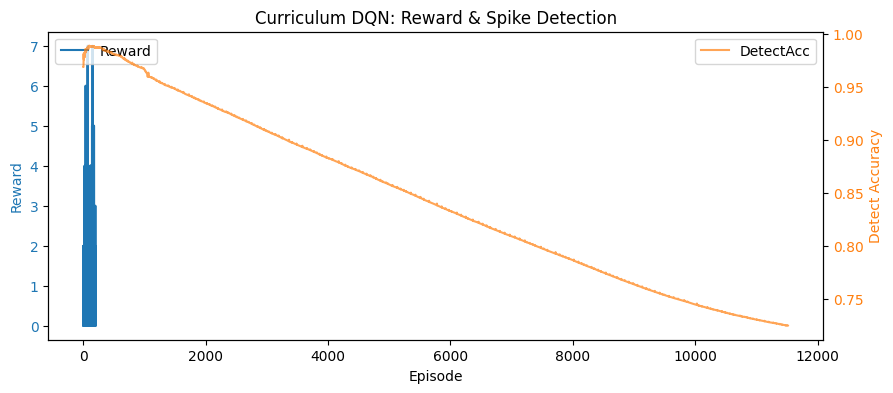

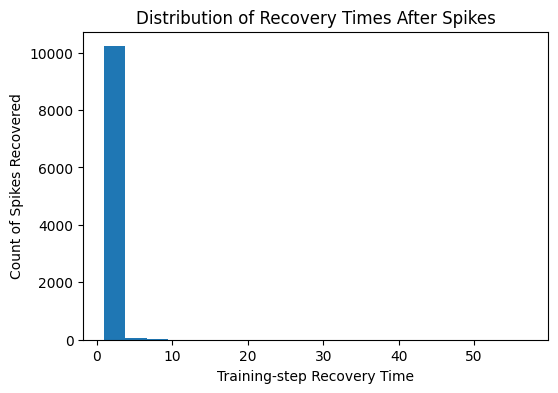

In [9]:
# Episodes vs Reward & Detection Accuracy
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(rewards,       label="Reward", color="tab:blue")
ax1.set_xlabel("Episode"); ax1.set_ylabel("Reward", color="tab:blue")
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(detect_acc,    label="DetectAcc", color="tab:orange", alpha=0.7)
ax2.set_ylabel("Detect Accuracy", color="tab:orange")
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title("Curriculum DQN: Reward & Spike Detection")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# Recovery Time Histogram
plt.figure(figsize=(6,4))
plt.hist(recovery_times, bins=20)
plt.xlabel("Training‐step Recovery Time")
plt.ylabel("Count of Spikes Recovered")
plt.title("Distribution of Recovery Times After Spikes")
plt.show()
